# I. Sample End-to-End Analysis
## A. Challenge
I want to look at loan (application process) info to predict who will default. Before I bias myself looking at the data that's available, I'm going to list out things I'd want to see where possible:
### 1. Info about the Borrower
- FICO score at time of application
- Employment status
- Household AGI (adjusted gross income) on last year's tax return
- Net worth
- Number of bankruptcies in last 20 years (though I don't know if records go beyond 10 years)
- Current or past home ownership
- Marital status
- Highest attained education level
- Age
- Race

### 2. Info about the Loan, Maybe with Borrower Info Baked In
- Loan size
- Interest rate
- Debt-to-income ratio
- Required payment-to-income ratio


## B. Finding the Data
### 1. Concerns About Data Sets:
- Too simplistic, not enough "features"
- Low sample size (under 10,000)
- Imbalanced results, which plays into the above
- Lots of features, but too many null values which would render many useless

### 2. Where To Look:
#### A. Kaggle - The LeetCode of ML/Data Science:
I heard about this site because it has competitions, a leaderboard, and curated data sets. What I didn't know was that there's an unmoderated GitHub-like free-for-all where where anyone can post a data set without a README explaining what the data is, or what outcomes were being measured, and there's nothing stopping users from contributing poorly worded or even erroneous interpretations of the data set! That was a real letdown.

#### B. Hugging Face:
This appears to be GitHub-like web site for data sets, where I can search by row count, topic, data format etc. My shoot-from-the-hip criticisms are:
- Unlike Kaggle, some of these appear aimless in nature. For example I can find data on social media posts (in English), translated to their Arabic equivalent. No upvote counts or any worthwhile "target" dimension offered.
- Lack of good documentation
- Crtyptic titles so site visitors are missing half the story until they click a link

#### C. Individual Schools/Research Facilities (What We Use This time):
In the interest of expediency, I grabbed the first one that fit from **UC Irvine**:
https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

These are 30,000 credit card holders from a bank in Taiwan. The first 24 columsn tell us inputs like age and the final "target" column tells us whether the card is in default now (Sept of 2005). 


# II. Generalized Order of Operations
This will be my 2nd rodeo since I got exposed to this process in the classic ##Housing Price Prediction## challenge in Chapter 2.

### A. Sense Check Around the Data ("Data Exploration")
### B. Data Preparation
#### 1. Cleaning: missing values, duplicates, potentially handling outliers
#### 2. Transformation: scaling, normalization, 1-hot encoding
#### 3. Splitting
### C. Initial Run
#### 1. Cross Fold Validation: With strong preference for stratification
#### 2. Evaluation of Initial Run
#### 3. Narrowing Feature Selection
### D. Final Run and Evaluation


# III. Start of End-to-End Analysis

## A. Data Exploration

We have 30,000 rows of data and 25 columns. Good start!

In [1]:
import pandas as pd
imported_credit_card_info = pd.read_csv("uc_irvine_credit_card_data.csv", header=1) #30,0001 rows, but first one is the header labels!
print(imported_credit_card_info.shape)

(30000, 25)


UCI documentation shows that this was for Sept of 2005, so "pay_3" column means "3 months ago in July 2005".

### 1. Payment Code Explanation
-2 = No consumption

-1 = Paid in full

0 = Paid the minimum due

1 = Payment 1 month late

2 = Payment 2 months late

### 2. Bill Amount Explanation
BILL_AMT4 = "Four months ago, what was the outstanding balance on the credit card?"

In [2]:
imported_credit_card_info.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 3. Gut-Check On Null Values
Not a single empty cell across 30K rows and 25 columns. Okay, so we can skip null-handling this exercise.

In [3]:
imported_credit_card_info.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

### 4. Gut-Check On Ranges, Medians, Standard Deviation
The first thing that stuck out to me was that there the lowest values of Bill Amounts were always negative, which didn't make sense. I guess that means the financial institution owed the cardholder money due to refunds or early/excessive payments? That checks out given the positive values in the first quartile, suggesting negative values are the exception and not the rule. We should NOT remove them from the data set.

In [4]:
imported_credit_card_info.describe().T # .T is used for Transpose

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


## B. Data Preparation
### 1. Removing Duplicates?
No duplicates found (as the UCI documentation claimed)

In [5]:
duplicate_id_rows = imported_credit_card_info[imported_credit_card_info["ID"].duplicated(keep=False)]
duplicate_id_rows.sort_values(by="ID")

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month


### 2. Scaling and Normalization
Skipping

### 3. Feature Engineering + 1 Hot Encoding
I really considered putting in some features like:
- If someone has a negative balance, maybe that means they are a true "Boy Scout" customer who won't default and clearly has economic means...or maybe it means they are tight on cash and calling in to demand chargebacks, thus creating a negative balance!
- If someone's bill payments matched or exceeded oustanding balances, would that necessarily make them a good customer? It's hard to say given that credit cards have different timings on when the month closes out, and we don't know if someone is paying big in one month is actually underpaying an older bill. Better to just leave this alone.

### 4. Splitting
Let's randomize the order of all 30K data points, then take
- 80% (24,000) for training
- 20% (6,000) for testing later

But to do that, I will first separate features (x values) from labels (y values)

In [6]:
imported_credit_card_info = imported_credit_card_info.sample(frac=1, random_state=42).reset_index(drop=True)
imported_credit_card_info.head() #confirming order is now randomized

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2309,30000,1,2,2,25,0,0,0,0,...,12580,13716,14828,1500,2000,1500,1500,1500,2000,0
1,22405,150000,2,1,2,26,0,0,0,0,...,101581,77741,77264,4486,4235,3161,2647,2669,2669,0
2,23398,70000,2,3,1,32,0,0,0,0,...,69753,70111,70212,2431,3112,3000,2438,2500,2554,0
3,25059,130000,1,3,2,49,0,0,0,0,...,16898,11236,6944,1610,1808,7014,27,7011,4408,0
4,2665,50000,2,2,2,36,0,0,0,0,...,19574,20295,19439,2000,1500,1000,1800,0,1000,1


In [7]:
from sklearn.model_selection import train_test_split

target_column = 'default payment next month'

# features, and yes a I know a lot of people use a capital X but it's giving me an OCD attack being inconsitent with a lowercase y
x = imported_credit_card_info.drop(columns=[target_column])

y = imported_credit_card_info[target_column] # target values, whether it was in default or not

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

## C. Initial Run
### 1. Bring in the Random Forest Tool 

In [8]:
from sklearn.ensemble import RandomForestClassifier

random_forest_instance = RandomForestClassifier(
    n_estimators=500,        # number of trees not limited by CPU processing because it's offline, might double it later
    max_depth=10,          # I am choosing NOT to let the trees grow fully, to avoid over-fitting issues
    random_state=44,
    n_jobs=-1                 # something about using the CPU cores
)

### 2. Cross Validation, Setting 4 Folds
We'll chop the training data of 24,000 into 4 piles of 6,000 rows (A B C D). The way cross-validation works is essentially a round robin tournament where A B and C will be trained and tested on D, then ABD trained and tested vs C, etc.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
cv_scores = cross_val_score(random_forest_instance, x_train, y_train, cv=5, scoring='accuracy')
print(f"5-fold CV accuracy: {cv_scores.mean():.5f} ± {cv_scores.std():.5f}")

5-fold CV accuracy: 0.82233 ± 0.00146


### 3. Evaluation of First Run
So we have our basedline:
- Random Forest, with 500 trees, max depth 10 layers, and 5 k folds produced 82.1% accuracy with a standard deviation of +/- 3.7%
- Compare this to a data set with 22% default rate or 78% no defaults. That means we're noticeably better than chance, but nothing to brag about.

#### i. Precision vs. Recall
As we covered in Chapter 3 on the handwritten digits, classifyer, accuaracy alone isn't good enough. I could see a randomized distribution of digits zero to nine, predict "not 5", and be right 90% of the time in that ridiculous model.

Aas a reminder, Precision means "Chance that my flagged was correct" and Recall is "Chances that I flagged everything I was supposed to".

The bad news is that our first pass has a 35.2% Recall on "bad" customers who default on credit card payments. That means we **only caught ~1 out of 3 at-risk accounts** and failed to detect 2 of 3.

461 (correctly labeled) + 848 (incorrectly approveed)  = 1,309
461 (correctly labeled)/1309 (total flagged "bad") = 35.2%

For what it's worth, we were right 461 out of the (461 + 226) = 67% of the time on Precision, though we will discuss later why that matters less.

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

random_forest_instance.fit(x_train, y_train)

y_pred = random_forest_instance.predict(x_test)

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Precision (default=1): {precision:.4f}")
print(f"Recall    (default=1): {recall:.4f}")
print(f"F1 score  (default=1): {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:")
print(cm)

print("\nFull classification report:")
print(classification_report(y_test, y_pred, digits=4))


Precision (default=1): 0.6540
Recall    (default=1): 0.3606
F1 score  (default=1): 0.4649

Confusion matrix:
[[4415  254]
 [ 851  480]]

Full classification report:
              precision    recall  f1-score   support

           0     0.8384    0.9456    0.8888      4669
           1     0.6540    0.3606    0.4649      1331

    accuracy                         0.8158      6000
   macro avg     0.7462    0.6531    0.6768      6000
weighted avg     0.7975    0.8158    0.7947      6000



#### ii. Confusion Matrices
As we covered in Chapter 3 on the handwritten digits, classifyer, accuaracy alone isn't good enough. I could see a randomized distribution of digits zero to nine, predict "not 5", and be right 90% of the time in that ridiculous model.\

**Tolerance** levels were defaulted to 50%. If we lower it gradually, maybe we'll catch more of the bad guys, even if the tradeoff is falsely flagging the good guys.

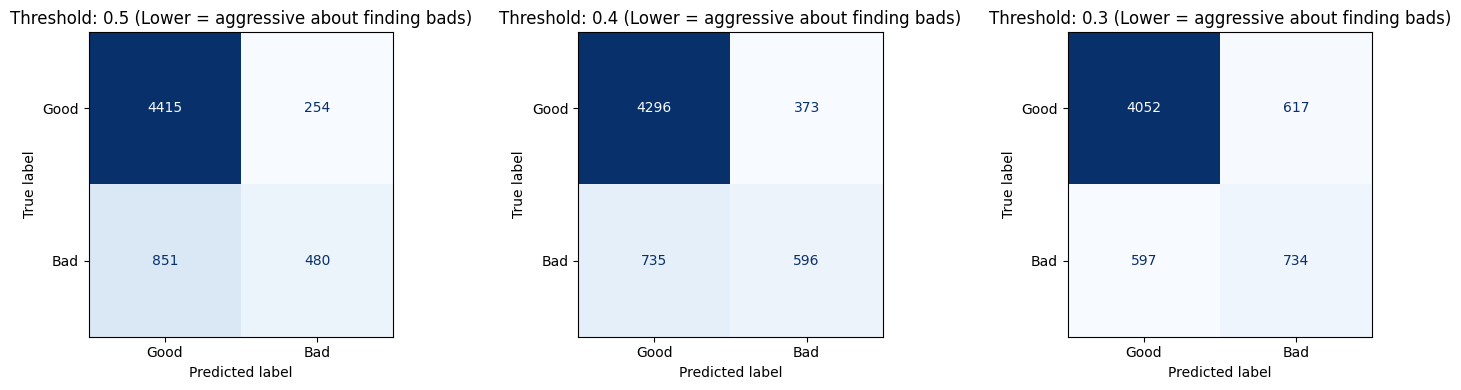

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

thresholds = [0.5, 0.4, 0.3] # the lever we're pulling in this scenario management
y_proba = random_forest_instance.predict_proba(x_test)[:, 1]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, thresh in zip(axes, thresholds):
    y_pred_thresh = (y_proba >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good", "Bad"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Threshold: {thresh} (Lower = aggressive about finding bads)")

plt.tight_layout()
plt.show()

#### iii. Feature Weights
Until shown otherwise, I'm going to assume there's some less relevant, or even confounding variables we can toss out. Removing low-impact features may remove overfitting bias and actually make the final model MORE accurate on the generalized training data. 

      Feature  Importance
6       PAY_0    0.238691
7       PAY_2    0.109021
8       PAY_3    0.065157
9       PAY_4    0.048122
10      PAY_5    0.044811
18   PAY_AMT1    0.040921
1   LIMIT_BAL    0.035532
11      PAY_6    0.035170
12  BILL_AMT1    0.033282
0          ID    0.032100
19   PAY_AMT2    0.032075
13  BILL_AMT2    0.030957
20   PAY_AMT3    0.030667
14  BILL_AMT3    0.027580
15  BILL_AMT4    0.026584
17  BILL_AMT6    0.026143
16  BILL_AMT5    0.025721
21   PAY_AMT4    0.025611
5         AGE    0.025375
23   PAY_AMT6    0.024620
22   PAY_AMT5    0.024214
3   EDUCATION    0.008678
4    MARRIAGE    0.005114
2         SEX    0.003853


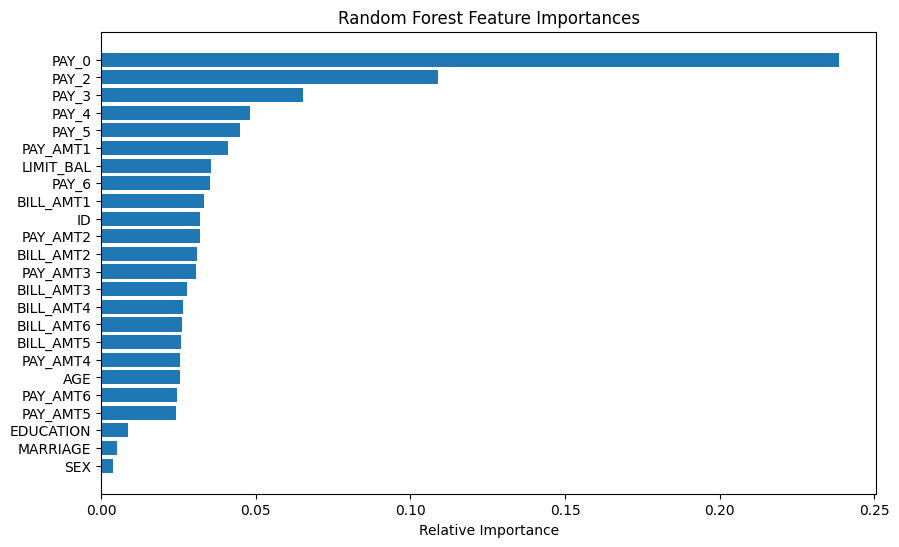

In [12]:
importances = random_forest_instance.feature_importances_

feat_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importances)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feat_importances['Feature'], feat_importances['Importance'])
plt.gca().invert_yaxis()  # Highest at top
plt.xlabel("Relative Importance")
plt.title("Random Forest Feature Importances")
plt.show()

#### IV. Feature Reduction Didn't Work
- If I were in a boardroom, explanability would be a consideration. So I tried an experiment where we only looked at payment history, limits, and age. For whatever reason, **recall dropped from 35% to 21%**, so let's back away from that strategy.

- Then I tried a milder approach - cutting the 3 least useful datapoints: Education, Marriage, and Sex. *Recall did not budge*.

- Is there a way we could invent a new feature? Not an obvious one comes to mind, so let's just move on.

#### V. A Second, Adjusted Random Forest
- So this time, we're using the whole data set but we're **lowering the threshold from 50% to 30%**, which makes us more aggressive about catching bad deadbeat customers.

The result we are focusing on is recall on the bad guys, which grew from **35% to 58%**. This is huge step in the right direction, even if not perfect.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

all_features = [
    "SEX", "MARRIAGE", "EDUCATION", "AGE", 
    "LIMIT_BAL", 
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"
]

target = "default payment next month"

x = imported_credit_card_info[all_features]
y = imported_credit_card_info[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=47, stratify=y
)

second_random_forest_instance = RandomForestClassifier(random_state=47)
second_random_forest_instance.fit(x_train, y_train)

y_proba = second_random_forest_instance.predict_proba(x_test)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)

print("=== Random Forest (threshold=0.3, random_state=47) ===")
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

=== Random Forest (threshold=0.3, random_state=47) ===
AUC: 0.770808381326387
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4673
           1       0.51      0.58      0.54      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.79      0.78      0.79      6000

